In [1]:
from __future__ import print_function
import time
import robobo
import cv2
import sys
import signal
import prey
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from vrep.error import VrepApiError 

Hardware Connection not available in python3 :(


In [2]:
class Actor(nn.Module):
    def __init__(self, state_dim=8, action_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, action_dim)
        
        self.log_scale = nn.Parameter(torch.full((action_dim,), 5.))
        self.register_parameter("log_scale", self.log_scale)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        loc = self.fc3(x)
        #loc = F.tanh(loc)
        loc = loc*50
        scale = torch.clamp(self.log_scale.exp(), min=0.001)
        return torch.distributions.Normal(loc, scale)


class Critic(nn.Module):
    def __init__(self, state_dim=8):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
    


In [3]:
class Agent(robobo.SimulationRobobo):
    def __init__(self, ip='192.168.1.133',
                 port=19997,
                 act_range = (20,100),
                 min_act = False,
                 act_granularity = 100,
                 discount=.95
                 ):
        super().__init__()
        super().connect(address=ip, port=port)
        self.discount = discount
        self.states = []
        self.actions = []
        self.training_results = {"critic" : [], "actor" : [], "reward" : []}
        self.min_act = act_range[0]
        self.max_act = act_range[1]
        random_policy = lambda state : np.random.randint(self.min_act,
                                                         self.max_act, 2)
        self.critic = Critic()
        self.actor = Actor()
        self.optim_c = optim.Adam(self.critic.parameters(), lr=0.00001)
        self.optim_a = optim.Adam(self.actor.parameters(), lr=0.000001)
        self.fps = 1000 / act_granularity
        self.act_granularity = act_granularity
        
    def start_sim(self): return self.play_simulation()
    def end_sim(self): return self.stop_world()
    def pause_sim(self): return self.pause_simulation()

    def mmove(self, r, l, t, cd=2.5):
        time.sleep(cd)
        self.move(r, l, t)
    def run_episode(self, n_steps=1000):
        self.n_steps = n_steps
        self.cumul_reward = 0.
        if self.is_simulation_running():
            self.end_sim()
        self.episode()
    def episode(self):
        self.cumul_reward = 0.
        print("Initializing simulation")
        self.start_sim()
        print("Starting Episode")
        print(f"FPS = {self.fps}")
        for step in range(self.n_steps):
            self.act()
        print("Closing simulation")
        self.end_sim()
    def get_state(self, use_cam = False,
                  normalize_ir = True,
                 invert_ir = True):
        # to do : edit parent + normalize
        X1 = torch.tensor([[ .2 if not _ else _ for _ in self.read_irs() ]])
        X1 = (X1 - 0.) / (.2 - 0.) if normalize_ir else X1
        X1 = 1 - X1 if invert_ir else X1
        
        X1 = X1.to(torch.float32)
        
        
        # X2 = self.get_image_front()
        
        
        if not use_cam:
            self.states.append(X1)
            return X1
        else:
            pass

    def act(self):

        state = self.states[-1] if len(self.states) > 0 else self.get_state()
        # actor
        action_dists = self.actor(state)
        action = action_dists.rsample()
        #action = torch.maximum(action, torch.Tensor([self.min_act, self.min_act])) if self.min_act else output
        # actuate
        control = action.clone().detach().numpy()
        self.actions.append(control)
        r, l = control[0][0], control[0][1]
        self.move(r, l, self.act_granularity)
        # observe next state and reward
        next_state = self.get_state()
        reward_next_state = action.sum() / 200 - next_state.sum() * 5
        #reward_next_state = action.abs().sum() - next_state.sum()
        # critic update
        self.optim_c.zero_grad()
        prediction_state = player.critic(state)
        prediction_next_state = player.critic(next_state)
        #target = self.discount * prediction_next_state.detach() + reward_next_state
        target = self.discount * prediction_next_state+ reward_next_state
        target = target.detach()
        loss_critic = ((prediction_state-target)**2).mean()
        loss_critic.backward()
        self.optim_c.step()
        # actor update
        advantage = reward_next_state + self.discount * prediction_next_state - prediction_state
        log_probs = action_dists.log_prob(action)
        loss_actor = (-log_probs * advantage.detach()).sum()
        self.optim_a.zero_grad()
        loss_actor.backward()
        nn.utils.clip_grad_norm_([p for g in self.optim_a.param_groups for p in g["params"]], .5) 
        self.optim_a.step()    
        self.cumul_reward += reward_next_state.item()
        self.training_results["critic"].append(loss_critic.item())
        self.training_results["actor"].append(loss_actor.item())
        self.training_results["reward"].append(reward_next_state.item())

In [4]:
class Agent(robobo.SimulationRobobo):
    def __init__(self, ip='192.168.1.133',
                 port=19997,
                 act_range = (20,40),
                 min_act = False,
                 act_granularity = 10,
                 discount=.95
                 ):
        super().__init__()
        super().connect(address=ip, port=port)
        self.discount = discount
        self.states = []
        self.actions = []
        self.action_dists = []
        self.training_results = {"critic" : [], "actor" : [], 
                                 "reward" : [], "reward-penalty" : [], "penalty" : []}
        self.min_act = act_range[0]
        self.max_act = act_range[1]
        random_policy = lambda state : np.random.randint(self.min_act,
                                                         self.max_act, 2)
        self.critic = Critic()
        self.actor = Actor()
        self.optim_c = optim.Adam(self.critic.parameters(), lr=1e-8)
        self.optim_a = optim.Adam(self.actor.parameters(), lr=1e-8)
        self.fps = 1000 / act_granularity
        self.act_granularity = act_granularity
        
    def start_sim(self): return self.play_simulation()
    def end_sim(self): return self.stop_world()
    def pause_sim(self): return self.pause_simulation()

    def mmove(self, r, l, t, cd=2.5):
        time.sleep(cd)
        self.move(r, l, t)
    def run_episode(self, n_steps=1000):
        self.n_steps = n_steps
        self.cumul_reward = 0.
        if self.is_simulation_running():
            self.end_sim()
        try:
            self.episode()
        except VrepApiError:
            self.run_episode(n_steps)
    def episode(self):
        self.cumul_reward = 0.
        print("Initializing simulation")
        self.start_sim()
        print("Starting Episode")
        print(f"FPS = {self.fps}")
        for step in range(self.n_steps):
            self.act()
        print("Closing simulation")
        self.end_sim()
    def get_state(self, use_cam = False,
                  normalize_ir = True,
                 invert_ir = True):
        # to do : edit parent + normalize
        X1 = torch.tensor([[ .2 if not _ else _ for _ in self.read_irs() ]])
        X1 = (X1 - 0.) / (.2 - 0.) if normalize_ir else X1
        #X1 = 1 - X1 if invert_ir else X1
        #X1 = 1 - X1
        X1 = X1.to(torch.float32)
        map(lambda x: x if x == 0.2 else x, X1)

        # X2 = self.get_image_front()
        if not use_cam:
            self.states.append(X1)
            return X1
        else:
            pass

    def act(self):
        state = self.states[-1] if len(self.states) > 0 else self.get_state()
        state = state.detach()
        # actor
        action_dists = self.actor(state)
        action = action_dists.rsample()
        action = action.detach()
  
        #action = torch.maximum(action, torch.Tensor([self.min_act, self.min_act])) if self.min_act else output
        
        # actuate
        action = action.detach()
        #control = np.maximum(control, np.array([[0, 0]]))
        self.actions.append(action)
        self.action_dists.append(action_dists)
        r, l = action[0][0], action[0][1]
        self.move(r, l, self.act_granularity)
        # observe next state and reward
        next_state = self.get_state().detach()
        reward = action.sum().detach() 
        penalty = next_state.sum()
        reward_next_state = next_state.sum()
        prediction_state = player.critic(state)
        prediction_next_state = player.critic(next_state)
        
        # actor update
        target = reward_next_state + self.discount * prediction_next_state
        #advantage = reward_next_state + self.discount * prediction_next_state - prediction_state
        advantage = target - prediction_state.detach()
        log_probs = action_dists.log_prob(action)
        loss_actor = (-log_probs * advantage.detach()).mean() 
        
        self.optim_a.zero_grad()
        loss_actor.backward()        

        #nn.utils.clip_grad_norm_([p for g in self.optim_a.param_groups for p in g["params"]], .5) 
        self.optim_a.step()   
                        
        # critic update
        self.optim_c.zero_grad()
 
        #target = self.discount * prediction_next_state.detach() + reward_next_state
        target = self.discount * prediction_next_state + reward_next_state
        target = target.detach()
        loss_critic = ((prediction_state-target)**2)#.mean()
        loss_critic.backward()
        #nn.utils.clip_grad_norm_([p for g in self.optim_c.param_groups for p in g["params"]], .5) 
        self.optim_c.step()
        
        
        self.cumul_reward += reward_next_state.item()
        self.training_results["critic"].append(loss_critic.item())
        self.training_results["actor"].append(loss_actor.item())
        self.training_results["reward-penalty"].append(reward_next_state.item())
        self.training_results["reward"].append(reward.item())
        self.training_results["penalty"].append(penalty.item())

In [5]:
player = Agent()

Connected to remote API server: client id 0


In [6]:
player.run_episode(500)

Initializing simulation
Starting Episode
FPS = 100.0
Initializing simulation
Starting Episode
FPS = 100.0


KeyboardInterrupt: 

In [ ]:
player.actor.log_scale

In [ ]:
player.actions

In [10]:
player.actor(torch.Tensor([[0,0,1,0,0,0,0,1]])).rsample()

tensor([[-13.9882,  -9.4714]], grad_fn=<AddBackward0>)

In [11]:
player.actor.fc3.weight.grad

tensor([[ 0.0000,  0.0000,  0.0000, -2.5687, -3.3644,  0.0000,  0.0000, -0.6245],
        [ 0.0000,  0.0000,  0.0000,  3.8529,  5.0465,  0.0000,  0.0000,  0.9368]])

In [12]:
player.critic.fc3.weight.grad

tensor([[-0.2837, -0.3477, -7.9421,  0.0000, -1.4261,  0.0000,  0.0000, -1.8248]])

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

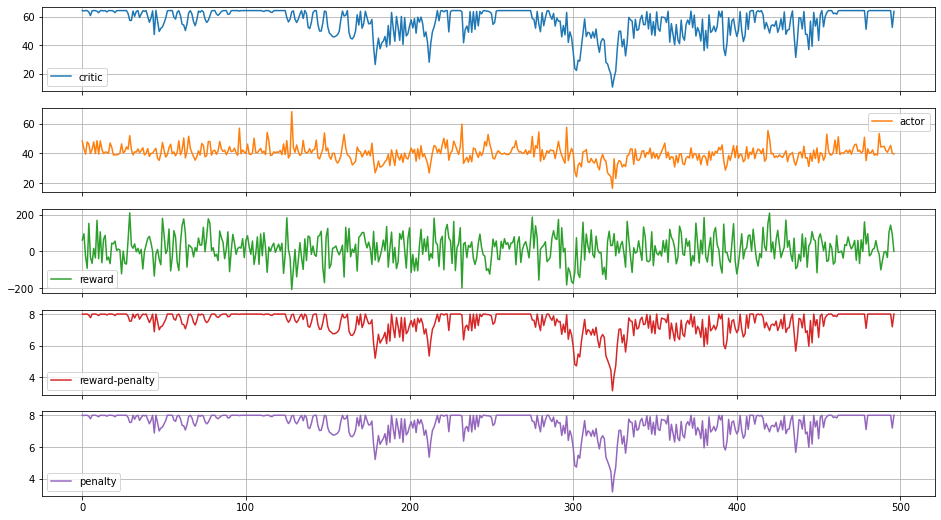

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)
pd.DataFrame(player.training_results).plot(subplots=True,grid=True)

In [7]:
player.end_sim()

In [ ]:
player.states[-1]


In [7]:
player.act(True)

TypeError: act() takes 1 positional argument but 2 were given

In [9]:
player.end_sim()

In [9]:
player.pause_sim()

In [7]:
player.start_sim()

In [13]:
##useful methods

rob.get_sim_time()

rob.get_image_front()

rob.read_irs()

rob.move()

rob.pause_simulation()

rob.stop_world()


469754